![image.png](attachment:image.png)

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix

from scipy.spatial.distance import pdist, squareform

from ydata_profiling import ProfileReport
from IPython.display import display

In [ ]:
df = pd.read_csv('online_shoppers_intention.csv')

In [ ]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
df.Revenue.value_counts(dropna=False)

,count
Revenue,
False,10422
True,1908


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [ ]:
# Reproduzirei os mesmos métodos de análise que utilizei na tarefa do módulo anterior, entretanto não substituirei os tipos de dados de "Month" e "VisitorType"
# Não há missing values

prof = ProfileReport(df, explorative=True, minimal=True)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 37.77it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Não há missing values entre os dados estudados. Entretanto, há uma grande quantidade de dados numéricos iguais a 0, variando entre, aproximadamente 9% dos dados da variável ProductRelated_Duration à, aproximadamente, 90% dos dados de SpecialDay. A distribuição dos dados observados segue uma padronização entre os valores não nulos, estando distribuidos de forma semelhantes e/ou havendo uma distribuição muito semelhante a uma regressão linear.<br>
Percebemos uma grande variabilidade dos valores de tempo de duração de visitas no site, considerando a descrição das variáveis entende-se que essa diferença entre valores é comum e não é nescessário uma padronização deles.<br>
Entretanto o valor de tipo de visitantes (novos visitantes, visitantes recorrentes ou outros ) tem poucas repostas como "others" (85), então, podemos considerar esse valor como irrelevante, e os exluirei, uma vez que essa resposta não parece ter significado de importância. Assim reduzirei as possibilidades de respostas para essa pergunta.

In [ ]:
# Reduzirei as opções de respostas para "VisitorType" retirando as que tem valores "Others"
print("Como são distribuidos os valores se há a categoria Others")
display(df[["VisitorType", "Revenue"]].value_counts())

print("-"*200)

print("Como são distribuidos os valores se não há a categoria Others")
df = df.drop(df[df["VisitorType"] == "Other"].index)
df[["VisitorType"]].value_counts()

Como são distribuidos os valores se há a categoria Others


VisitorType        Revenue
Returning_Visitor  False      9081
                   True       1470
New_Visitor        False      1272
                   True        422
Other              False        69
                   True         16
Name: count, dtype: int64

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Como são distribuidos os valores se não há a categoria Others


,count
VisitorType,
Returning_Visitor,10551
New_Visitor,1694


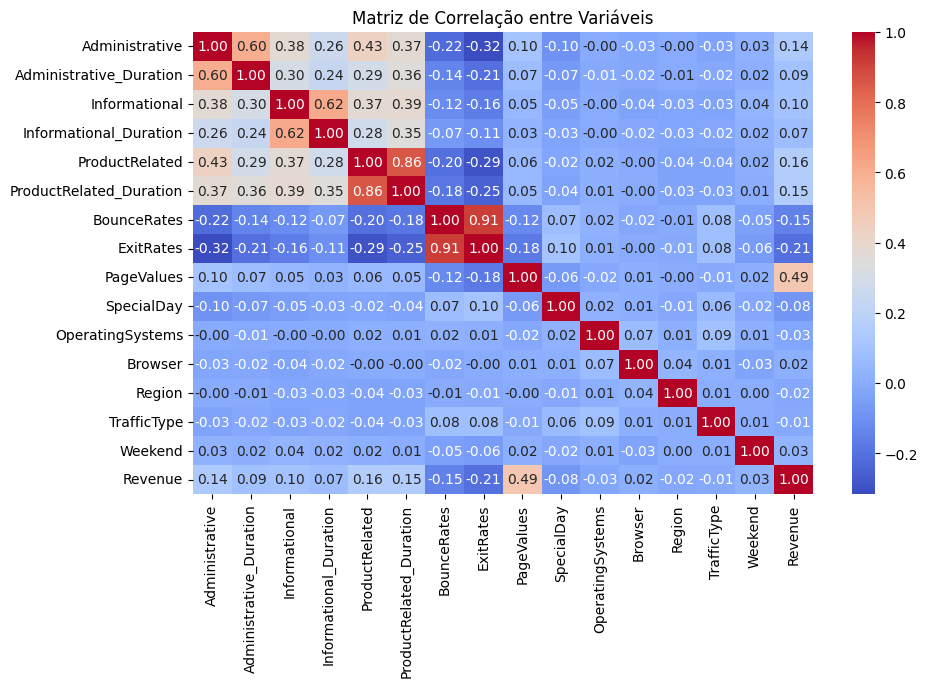

In [ ]:
%matplotlib inline
# Criação de heatmap para análise de relação entre variáveis
# a função corr() ignora osvalores nulos

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação entre Variáveis")
plt.show()

Considerando o desenho da matrizde correlação encontrada percebemos uma esperada e clara forte relação entre as variáveis já esperadas, sendo a relação entre "BounceRates" x "ExitRates" o de melhor correlação (0,91), seguindo do "ProductRelated" x "ProductRelated_Duration" (0,86), "Informational" x "Informational_Duration" (0,62) e "Administrative" x "Administrative_Duration" (0,6).<br>
Além desses percebemos uma boa relação entre "PageValues" x "Revenue" (0,49), sendo essa uma relação muito interessante, entre a média de páginas visitadas para um visitante fechar a compra.<br>
O "Administrative" x "ProductRelated" tem relação de 0,43, mostrando uma relação relativamente importante entre os visitantes de páginas administrativas e de páginas de produtos.

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [ ]:
# Reduzindo o número de variáveis em df, considerando o resultado da matriz de correlação anterios. Utilizarei a quantidade de acessos no lugardo tempo uma vez que entendo que essa é mais importante,
# uma vezque uma pessoa pode acessar uma página e simplesmente esquecê-la perdida nas abas abertas e por serem valores mais padronizados.
df = df[["Administrative", "Informational", "ProductRelated", "BounceRates", "PageValues",	"SpecialDay", "Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Revenue"]]

print('Variáveis categóricas: "BouncesRates", "Revenue""')
print('Variáveis de datas: "SpecialDay", "Month", "Weekend"')

Variáveis categóricas: "BouncesRates", "Revenue""
Variáveis de datas: "SpecialDay", "Month", "Weekend"


In [ ]:
# Divisão das bases X e y
var = df.columns[df.columns != "Revenue"]
var_cat = var[-1]

In [ ]:
df_g = pd.get_dummies(df[var].dropna())
df_g.head()

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0,0,1,0.20,0.0,0.0,1,1,1,1,...,True,False,False,False,False,False,False,False,False,True
1,0,0,2,0.00,0.0,0.0,2,2,1,2,...,True,False,False,False,False,False,False,False,False,True
2,0,0,1,0.20,0.0,0.0,4,1,9,3,...,True,False,False,False,False,False,False,False,False,True
3,0,0,2,0.05,0.0,0.0,3,2,2,4,...,True,False,False,False,False,False,False,False,False,True
4,0,0,10,0.02,0.0,0.0,3,3,1,4,...,True,False,False,False,False,False,False,False,False,True


In [ ]:
df_g.columns.values

array(['Administrative', 'Informational', 'ProductRelated', 'BounceRates',
       'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser',
       'Region', 'TrafficType', 'Weekend', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_New_Visitor',
       'VisitorType_Returning_Visitor'], dtype=object)

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [ ]:
vars_cat = [True if x in {"Month_Aug", "Month_Dec", "Month_Feb", "Month_Jul", "Month_June", "Month_Mar", "Month_May", "Month_Nov", "Month_Oct", "Month_Sep", "VisitorType_New_Visitor", "VisitorType_Returning_Visitor"} else False for x in df_g.columns]

distancia_gower = gower_matrix(df_g, cat_features=vars_cat)

gdv = squareform(distancia_gower,force='tovector')

Z = linkage(gdv, method='complete')

Leaves = 857


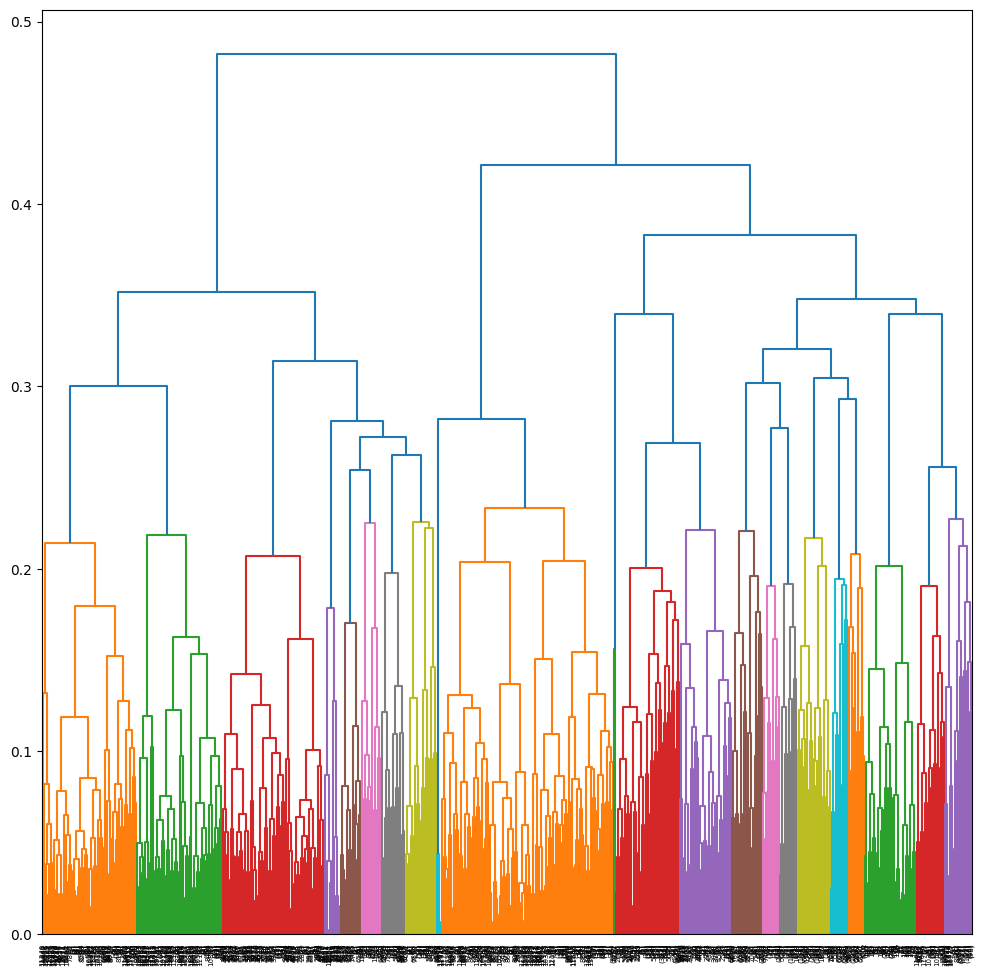

In [ ]:
# Dendograma
fig,axs = plt.subplots(1,1,figsize=(12,12))
dn = dendrogram(Z, truncate_mode='level',p=10,show_leaf_counts=True,ax=axs, color_threshold=.24)
print(f"Leaves = {len(dn['leaves'])}")

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [ ]:
# Análise descitiva para 3 grupos
df_g['grupo3'] = fcluster(Z, 3 , criterion='maxclust')
df_g.grupo3.value_counts()

,count
grupo3,
3,9221
1,1694
2,1330


In [ ]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12245 entries, 0 to 12329
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12245 non-null  int64  
 1   Informational                  12245 non-null  int64  
 2   ProductRelated                 12245 non-null  int64  
 3   BounceRates                    12245 non-null  float64
 4   PageValues                     12245 non-null  float64
 5   SpecialDay                     12245 non-null  float64
 6   OperatingSystems               12245 non-null  int64  
 7   Browser                        12245 non-null  int64  
 8   Region                         12245 non-null  int64  
 9   TrafficType                    12245 non-null  int64  
 10  Weekend                        12245 non-null  bool   
 11  Month_Aug                      12245 non-null  bool   
 12  Month_Dec                      12245 non-null  bool

In [ ]:
df_3 = df.reset_index().merge(df_g.reset_index(), how='left')
df_3.groupby(['VisitorType', 'Revenue','grupo3'])['index'].count().unstack().fillna(0).astype(int)

grupo3                        1     2     3
VisitorType       Revenue                  
New_Visitor       False    1272     0     0
                  True      422     0     0
Returning_Visitor False       0  1202  7879
                  True        0   128  1342

In [ ]:
# Análise descitiva para 4 grupos
df_g['grupo4'] = fcluster(Z, 4 , criterion='maxclust')
df_g.grupo4.value_counts()

,count
grupo4,
4,6175
3,3046
1,1694
2,1330


In [ ]:
df_4 = df.reset_index().merge(df_g.reset_index(), how='left')
df_4.groupby(['VisitorType', 'Revenue', 'grupo4'])['index'].count().unstack().fillna(0).astype(int)

grupo4                        1     2     3     4
VisitorType       Revenue                        
New_Visitor       False    1272     0     0     0
                  True      422     0     0     0
Returning_Visitor False       0  1202  2769  5110
                  True        0   128   277  1065

Observando ambas as divisões em grupos estudadas (entre 3 e 4) percebemos que a divisão entre 4 grupos de dados parece mais homogênea.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

In [ ]:
print("Para 4 clusters")
display(df_4.groupby('grupo4')[['BounceRates', 'Revenue']].mean())

Para 4 clusters


,BounceRates,Revenue
grupo4,,
1,0.005261,0.249115
2,0.023046,0.096241
3,0.029111,0.090939
4,0.023013,0.172470


Considerando os grupos criados a partir da segmentação em quatro partes, percebe-se uma melhor representação dos clientes-alvo no grupo 1.

Como o objetivo do estudo é identificar grupos com maior Revenue e, ao mesmo tempo, com menores Bounce Rates, pode-se sugerir que o grupo 1 apresenta uma melhor compensação entre os indicadores analisados.